## LSTM Model

## Install Package

In [3]:
!pip install torch

In [22]:
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch

import torch.nn as nn

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/cleaned_data.csv', parse_dates=['date'], index_col='date')

The first thing we must do is to properly shape the input data. When modeling a time series by LSTM RNN, it is crucial to to properly shape the input data in a sliding windows format. In this application, the data is given as monthly data. So, for example, we can use a 12 steps prediction window. This means that we use 12 samples of data (data of an entire year).

In [4]:
prediction_window=12
n_input=12 
n_features=1

In [5]:
train = df.copy()

### Scaling the Data
We use `MinMaxScaler` to scale the training data to a range between 0 and 1.  
This is important for LSTM models because they perform better when input data is normalized, ensuring faster convergence and improved performance.

In [6]:

scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)

### Creating Sliding Windows
This function generates input-output pairs for the LSTM model:  
- **Purpose**: To prepare sequences (`X_train`) and their corresponding targets (`y_train`).  
- **Why we need it**: LSTMs require sequential data as input to learn patterns over time. The sliding window approach extracts overlapping sequences of length `n_input` from the dataset.


In [7]:
def sliding_windows(data, n_input):
    X_train=[]
    y_train=[]
    for i in range(n_input,len(data)):
        X_train.append(data[i-n_input:i])
        y_train.append(data[i])
    return np.array(X_train), np.array(y_train)

In [8]:
x, y = sliding_windows(scaled_train, prediction_window)

In [40]:
train_size = int(len(train) - 36)
valid_size = len(train) - train_size
test_size = len(x) - train_size - valid_size  

# Split the data
X_train = torch.Tensor(np.array(x[:train_size]))
y_train = torch.Tensor(np.array(y[:train_size]))

X_valid = torch.Tensor(np.array(x[train_size:train_size + valid_size]))
y_valid = torch.Tensor(np.array(y[train_size:train_size + valid_size]))

X_test = torch.Tensor(np.array(x[train_size + valid_size:]))
y_test = torch.Tensor(np.array(y[train_size + valid_size:]))

### Converting Data to Tensors
- **Purpose**: Convert the data into PyTorch tensors for compatibility with the LSTM model.  
- **Why we need it**: PyTorch models require input and output data in tensor format.  
- Data is split into training and validation sets, with the training set used for model learning and the validation set used for performance evaluation.


In [41]:

dataX = torch.Tensor(np.array(x))
dataY = torch.Tensor(np.array(y))

X_train = torch.Tensor(np.array(x[:train_size]))
y_train = torch.Tensor(np.array(y[:train_size]))

X_valid = torch.Tensor(np.array(x[train_size:len(x)]))
y_valid = torch.Tensor(np.array(y[train_size:len(y)]))

### Defining the LSTM Model
- **Purpose**: Create an LSTM-based neural network for time-series prediction.  
- **Why we need it**: LSTM layers are designed to capture sequential dependencies in data, making them ideal for time-series tasks.  

**Key Components**:  
1. **LSTM Layer**: Processes sequential data and learns temporal patterns.  
   - Parameters:  
     - `input_size`: Number of features in the input data.  
     - `hidden_size`: Number of units in the hidden layer.  
     - `num_layers`: Number of stacked LSTM layers.  
2. **Fully Connected Layer**: Maps the LSTM output to the target prediction.  

**Forward Pass**:  
- Initializes hidden (`h0`) and cell states (`c0`) to zeros.  
- Passes input data through the LSTM layer.  
- Uses the last hidden state to make predictions via the fully connected layer.


In [42]:

class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMNet, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  

        out, (h_out, c_out) = self.lstm(x, (h0, c0))

        out = self.fc(h_out[-1])

        return out

In [43]:
EPOCHS = 2000
LEARNING_RATE = 0.005
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

INPUT_SIZE = n_features
HIDDEN_SIZE = 100
NUM_LAYERS = 1

In [44]:
model = LSTMNet(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS)
model.to(DEVICE)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

early_stopping_patience = 150
early_stopping_counter = 0
valid_loss_min = float('inf')




### Training the LSTM Model
- **Purpose**: Train the LSTM model using the training data and evaluate it on the validation set during each epoch.  
- **Why we need it**: The training loop updates model weights to minimize the loss, while validation monitors performance to avoid overfitting.  

**Key Steps**:  
1. **Training Phase**:  
   - `model.train()`: Puts the model in training mode.  
   - Gradients are cleared, predictions are made, and loss is computed.  
   - Backpropagation (`train_loss.backward()`) updates model weights using the optimizer.  

2. **Validation Phase**:  
   - `model.eval()`: Puts the model in evaluation mode (disables gradient calculations).  
   - Validation loss is computed without updating the weights.  

3. **Early Stopping**:  
   - Saves the model if validation loss improves.  
   - Stops training if the validation loss does not improve for `early_stopping_patience` epochs.  

4. **Output**:  
   - Training and validation loss are printed for each epoch to track progress.  


In [45]:
for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()

    output = model(X_train)
    train_loss = criterion(output, y_train)

    train_loss.backward()
    optimizer.step()

    with torch.no_grad():
        model.eval()
        output_val = model(X_valid)
        valid_loss = criterion(output_val, y_valid)

        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), './state_dict.pt')
            print(f'Epoch {epoch + 1}: Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...')
            valid_loss_min = valid_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter > early_stopping_patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break

    # Print training and validation loss for each epoch
    print(f'\t Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f} | Best Validation Loss: {valid_loss_min:.4f}\n')


Epoch 1: Validation loss decreased (inf --> 0.503655). Saving model...
	 Train Loss: 0.2460 | Validation Loss: 0.5037 | Best Validation Loss: 0.5037

Epoch 2: Validation loss decreased (0.503655 --> 0.302972). Saving model...
	 Train Loss: 0.1628 | Validation Loss: 0.3030 | Best Validation Loss: 0.3030

Epoch 3: Validation loss decreased (0.302972 --> 0.074618). Saving model...
	 Train Loss: 0.0926 | Validation Loss: 0.0746 | Best Validation Loss: 0.0746

Epoch 4: Validation loss decreased (0.074618 --> 0.027774). Saving model...
	 Train Loss: 0.0693 | Validation Loss: 0.0278 | Best Validation Loss: 0.0278

	 Train Loss: 0.0835 | Validation Loss: 0.0853 | Best Validation Loss: 0.0278

	 Train Loss: 0.0556 | Validation Loss: 0.1464 | Best Validation Loss: 0.0278

	 Train Loss: 0.0547 | Validation Loss: 0.1765 | Best Validation Loss: 0.0278

	 Train Loss: 0.0582 | Validation Loss: 0.1756 | Best Validation Loss: 0.0278

	 Train Loss: 0.0568 | Validation Loss: 0.1486 | Best Validation Loss

	 Train Loss: 0.0021 | Validation Loss: 0.0067 | Best Validation Loss: 0.0067

	 Train Loss: 0.0021 | Validation Loss: 0.0067 | Best Validation Loss: 0.0067

	 Train Loss: 0.0021 | Validation Loss: 0.0068 | Best Validation Loss: 0.0067

	 Train Loss: 0.0021 | Validation Loss: 0.0067 | Best Validation Loss: 0.0067

	 Train Loss: 0.0021 | Validation Loss: 0.0067 | Best Validation Loss: 0.0067

Epoch 103: Validation loss decreased (0.006718 --> 0.006704). Saving model...
	 Train Loss: 0.0021 | Validation Loss: 0.0067 | Best Validation Loss: 0.0067

	 Train Loss: 0.0021 | Validation Loss: 0.0067 | Best Validation Loss: 0.0067

	 Train Loss: 0.0021 | Validation Loss: 0.0067 | Best Validation Loss: 0.0067

	 Train Loss: 0.0021 | Validation Loss: 0.0067 | Best Validation Loss: 0.0067

	 Train Loss: 0.0021 | Validation Loss: 0.0067 | Best Validation Loss: 0.0067

	 Train Loss: 0.0021 | Validation Loss: 0.0067 | Best Validation Loss: 0.0067

Epoch 109: Validation loss decreased (0.006704 --> 0.

Epoch 166: Validation loss decreased (0.006494 --> 0.006492). Saving model...
	 Train Loss: 0.0021 | Validation Loss: 0.0065 | Best Validation Loss: 0.0065

Epoch 167: Validation loss decreased (0.006492 --> 0.006489). Saving model...
	 Train Loss: 0.0021 | Validation Loss: 0.0065 | Best Validation Loss: 0.0065

Epoch 168: Validation loss decreased (0.006489 --> 0.006485). Saving model...
	 Train Loss: 0.0020 | Validation Loss: 0.0065 | Best Validation Loss: 0.0065

Epoch 169: Validation loss decreased (0.006485 --> 0.006480). Saving model...
	 Train Loss: 0.0020 | Validation Loss: 0.0065 | Best Validation Loss: 0.0065

Epoch 170: Validation loss decreased (0.006480 --> 0.006475). Saving model...
	 Train Loss: 0.0020 | Validation Loss: 0.0065 | Best Validation Loss: 0.0065

Epoch 171: Validation loss decreased (0.006475 --> 0.006472). Saving model...
	 Train Loss: 0.0020 | Validation Loss: 0.0065 | Best Validation Loss: 0.0065

Epoch 172: Validation loss decreased (0.006472 --> 0.00646

Epoch 224: Validation loss decreased (0.006287 --> 0.006283). Saving model...
	 Train Loss: 0.0020 | Validation Loss: 0.0063 | Best Validation Loss: 0.0063

Epoch 225: Validation loss decreased (0.006283 --> 0.006280). Saving model...
	 Train Loss: 0.0020 | Validation Loss: 0.0063 | Best Validation Loss: 0.0063

Epoch 226: Validation loss decreased (0.006280 --> 0.006276). Saving model...
	 Train Loss: 0.0020 | Validation Loss: 0.0063 | Best Validation Loss: 0.0063

Epoch 227: Validation loss decreased (0.006276 --> 0.006272). Saving model...
	 Train Loss: 0.0020 | Validation Loss: 0.0063 | Best Validation Loss: 0.0063

Epoch 228: Validation loss decreased (0.006272 --> 0.006269). Saving model...
	 Train Loss: 0.0020 | Validation Loss: 0.0063 | Best Validation Loss: 0.0063

Epoch 229: Validation loss decreased (0.006269 --> 0.006265). Saving model...
	 Train Loss: 0.0020 | Validation Loss: 0.0063 | Best Validation Loss: 0.0063

Epoch 230: Validation loss decreased (0.006265 --> 0.00626

Epoch 281: Validation loss decreased (0.006060 --> 0.006055). Saving model...
	 Train Loss: 0.0019 | Validation Loss: 0.0061 | Best Validation Loss: 0.0061

Epoch 282: Validation loss decreased (0.006055 --> 0.006050). Saving model...
	 Train Loss: 0.0019 | Validation Loss: 0.0061 | Best Validation Loss: 0.0061

Epoch 283: Validation loss decreased (0.006050 --> 0.006046). Saving model...
	 Train Loss: 0.0019 | Validation Loss: 0.0060 | Best Validation Loss: 0.0060

Epoch 284: Validation loss decreased (0.006046 --> 0.006041). Saving model...
	 Train Loss: 0.0019 | Validation Loss: 0.0060 | Best Validation Loss: 0.0060

Epoch 285: Validation loss decreased (0.006041 --> 0.006036). Saving model...
	 Train Loss: 0.0019 | Validation Loss: 0.0060 | Best Validation Loss: 0.0060

Epoch 286: Validation loss decreased (0.006036 --> 0.006031). Saving model...
	 Train Loss: 0.0019 | Validation Loss: 0.0060 | Best Validation Loss: 0.0060

Epoch 287: Validation loss decreased (0.006031 --> 0.00602

Epoch 334: Validation loss decreased (0.005677 --> 0.005667). Saving model...
	 Train Loss: 0.0018 | Validation Loss: 0.0057 | Best Validation Loss: 0.0057

Epoch 335: Validation loss decreased (0.005667 --> 0.005656). Saving model...
	 Train Loss: 0.0018 | Validation Loss: 0.0057 | Best Validation Loss: 0.0057

Epoch 336: Validation loss decreased (0.005656 --> 0.005645). Saving model...
	 Train Loss: 0.0018 | Validation Loss: 0.0056 | Best Validation Loss: 0.0056

Epoch 337: Validation loss decreased (0.005645 --> 0.005634). Saving model...
	 Train Loss: 0.0018 | Validation Loss: 0.0056 | Best Validation Loss: 0.0056

Epoch 338: Validation loss decreased (0.005634 --> 0.005623). Saving model...
	 Train Loss: 0.0018 | Validation Loss: 0.0056 | Best Validation Loss: 0.0056

Epoch 339: Validation loss decreased (0.005623 --> 0.005612). Saving model...
	 Train Loss: 0.0017 | Validation Loss: 0.0056 | Best Validation Loss: 0.0056

Epoch 340: Validation loss decreased (0.005612 --> 0.00560

	 Train Loss: 0.0018 | Validation Loss: 0.0050 | Best Validation Loss: 0.0049

	 Train Loss: 0.0015 | Validation Loss: 0.0060 | Best Validation Loss: 0.0049

Epoch 402: Validation loss decreased (0.004913 --> 0.004854). Saving model...
	 Train Loss: 0.0018 | Validation Loss: 0.0049 | Best Validation Loss: 0.0049

Epoch 403: Validation loss decreased (0.004854 --> 0.004852). Saving model...
	 Train Loss: 0.0016 | Validation Loss: 0.0049 | Best Validation Loss: 0.0049

	 Train Loss: 0.0017 | Validation Loss: 0.0054 | Best Validation Loss: 0.0049

	 Train Loss: 0.0016 | Validation Loss: 0.0053 | Best Validation Loss: 0.0049

Epoch 406: Validation loss decreased (0.004852 --> 0.004798). Saving model...
	 Train Loss: 0.0016 | Validation Loss: 0.0048 | Best Validation Loss: 0.0048

	 Train Loss: 0.0016 | Validation Loss: 0.0049 | Best Validation Loss: 0.0048

	 Train Loss: 0.0015 | Validation Loss: 0.0056 | Best Validation Loss: 0.0048

	 Train Loss: 0.0016 | Validation Loss: 0.0049 | Best V

	 Train Loss: 0.0013 | Validation Loss: 0.0059 | Best Validation Loss: 0.0033

	 Train Loss: 0.0018 | Validation Loss: 0.0033 | Best Validation Loss: 0.0033

	 Train Loss: 0.0012 | Validation Loss: 0.0037 | Best Validation Loss: 0.0033

	 Train Loss: 0.0018 | Validation Loss: 0.0038 | Best Validation Loss: 0.0033

	 Train Loss: 0.0012 | Validation Loss: 0.0055 | Best Validation Loss: 0.0033

	 Train Loss: 0.0016 | Validation Loss: 0.0035 | Best Validation Loss: 0.0033

	 Train Loss: 0.0011 | Validation Loss: 0.0033 | Best Validation Loss: 0.0033

Epoch 489: Validation loss decreased (0.003256 --> 0.003245). Saving model...
	 Train Loss: 0.0015 | Validation Loss: 0.0032 | Best Validation Loss: 0.0032

	 Train Loss: 0.0011 | Validation Loss: 0.0047 | Best Validation Loss: 0.0032

	 Train Loss: 0.0014 | Validation Loss: 0.0038 | Best Validation Loss: 0.0032

Epoch 492: Validation loss decreased (0.003245 --> 0.002924). Saving model...
	 Train Loss: 0.0011 | Validation Loss: 0.0029 | Best 

	 Train Loss: 0.0004 | Validation Loss: 0.0016 | Best Validation Loss: 0.0016

	 Train Loss: 0.0004 | Validation Loss: 0.0016 | Best Validation Loss: 0.0016

	 Train Loss: 0.0004 | Validation Loss: 0.0016 | Best Validation Loss: 0.0016

	 Train Loss: 0.0004 | Validation Loss: 0.0016 | Best Validation Loss: 0.0016

	 Train Loss: 0.0004 | Validation Loss: 0.0016 | Best Validation Loss: 0.0016

	 Train Loss: 0.0004 | Validation Loss: 0.0016 | Best Validation Loss: 0.0016

	 Train Loss: 0.0004 | Validation Loss: 0.0016 | Best Validation Loss: 0.0016

	 Train Loss: 0.0004 | Validation Loss: 0.0016 | Best Validation Loss: 0.0016

	 Train Loss: 0.0004 | Validation Loss: 0.0016 | Best Validation Loss: 0.0016

	 Train Loss: 0.0004 | Validation Loss: 0.0016 | Best Validation Loss: 0.0016

	 Train Loss: 0.0004 | Validation Loss: 0.0016 | Best Validation Loss: 0.0016

	 Train Loss: 0.0004 | Validation Loss: 0.0016 | Best Validation Loss: 0.0016

	 Train Loss: 0.0004 | Validation Loss: 0.0016 | Bes

	 Train Loss: 0.0007 | Validation Loss: 0.0022 | Best Validation Loss: 0.0012

	 Train Loss: 0.0005 | Validation Loss: 0.0016 | Best Validation Loss: 0.0012

	 Train Loss: 0.0009 | Validation Loss: 0.0020 | Best Validation Loss: 0.0012

	 Train Loss: 0.0005 | Validation Loss: 0.0027 | Best Validation Loss: 0.0012

	 Train Loss: 0.0006 | Validation Loss: 0.0013 | Best Validation Loss: 0.0012

	 Train Loss: 0.0006 | Validation Loss: 0.0013 | Best Validation Loss: 0.0012

	 Train Loss: 0.0004 | Validation Loss: 0.0027 | Best Validation Loss: 0.0012

	 Train Loss: 0.0006 | Validation Loss: 0.0014 | Best Validation Loss: 0.0012

	 Train Loss: 0.0004 | Validation Loss: 0.0012 | Best Validation Loss: 0.0012

	 Train Loss: 0.0006 | Validation Loss: 0.0020 | Best Validation Loss: 0.0012

	 Train Loss: 0.0005 | Validation Loss: 0.0019 | Best Validation Loss: 0.0012

	 Train Loss: 0.0005 | Validation Loss: 0.0012 | Best Validation Loss: 0.0012

	 Train Loss: 0.0005 | Validation Loss: 0.0014 | Bes

	 Train Loss: 0.0004 | Validation Loss: 0.0013 | Best Validation Loss: 0.0012

	 Train Loss: 0.0004 | Validation Loss: 0.0013 | Best Validation Loss: 0.0012

	 Train Loss: 0.0004 | Validation Loss: 0.0013 | Best Validation Loss: 0.0012

	 Train Loss: 0.0004 | Validation Loss: 0.0013 | Best Validation Loss: 0.0012

	 Train Loss: 0.0004 | Validation Loss: 0.0013 | Best Validation Loss: 0.0012

	 Train Loss: 0.0004 | Validation Loss: 0.0013 | Best Validation Loss: 0.0012

	 Train Loss: 0.0004 | Validation Loss: 0.0013 | Best Validation Loss: 0.0012

	 Train Loss: 0.0004 | Validation Loss: 0.0013 | Best Validation Loss: 0.0012

	 Train Loss: 0.0003 | Validation Loss: 0.0013 | Best Validation Loss: 0.0012

	 Train Loss: 0.0003 | Validation Loss: 0.0013 | Best Validation Loss: 0.0012

	 Train Loss: 0.0003 | Validation Loss: 0.0013 | Best Validation Loss: 0.0012

	 Train Loss: 0.0003 | Validation Loss: 0.0013 | Best Validation Loss: 0.0012

	 Train Loss: 0.0003 | Validation Loss: 0.0013 | Bes

In [46]:
with torch.no_grad():  
    predictions = model(X_valid) 
    predictions = predictions.numpy()  
    
    y_valid = y_valid  

    mse = mean_squared_error(y_valid, predictions)
    mae = mean_absolute_error(y_valid, predictions)
    

    print(f'Mean Squared Error (MSE): {mse:.4f}')
    print(f'Mean Absolute Error (MAE): {mae:.4f}')


Mean Squared Error (MSE): 0.0013
Mean Absolute Error (MAE): 0.0280


In [56]:
# torch.save(model, 'lstm_model.pth')

In [47]:
model.load_state_dict(torch.load('./state_dict.pt'))

<All keys matched successfully>

In [48]:
valid_predict = model(X_valid)
y_pred_scaled = valid_predict.data.numpy()
y_pred = scaler.inverse_transform(y_pred_scaled)

In [49]:
df_pred=train.iloc[-24:]
df_pred['prediction']=y_pred

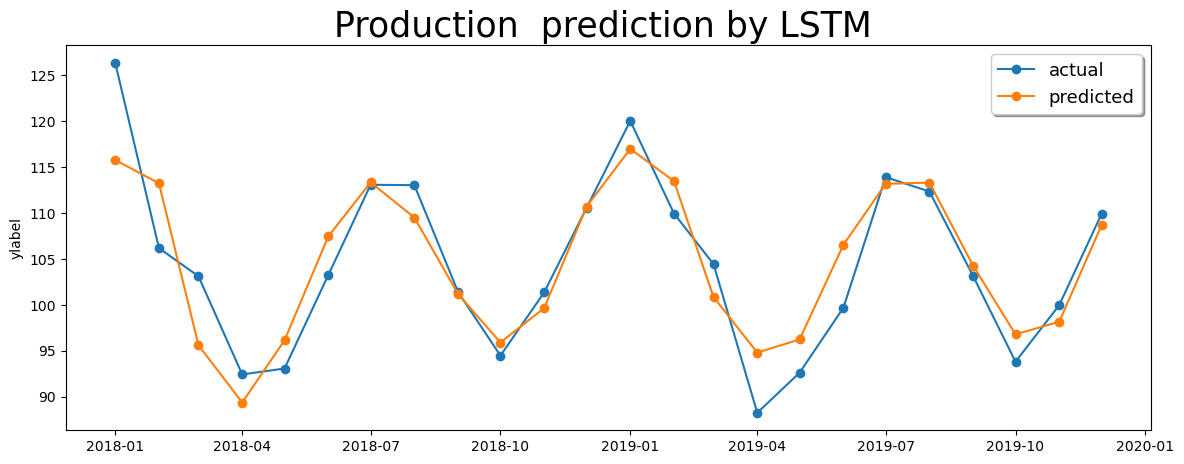

In [50]:
plt.figure(figsize=(14,5))
plt.plot(df_pred.index,df_pred["production"], label="actual", marker="o")
plt.plot(df_pred.index,df_pred["prediction"], label="predicted", marker="o")
plt.title("Production  prediction by LSTM ", fontsize=25)
plt.ylabel("ylabel")
plt.legend(title_fontsize=14, fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.show()

In [51]:
test_predictions = []

first_eval_batch = torch.Tensor(scaled_train[-n_input:]).reshape(1, n_input, n_features)  # (1, 12, 1)
current_batch = first_eval_batch

for _ in range(len(scaled_train[-n_input:])):  
    current_pred = model(current_batch)
    
    test_predictions.append(current_pred.item())  
    
    current_pred = current_pred.unsqueeze(0)  

    current_batch = torch.cat((current_batch[:, 1:, :], current_pred), dim=1)

print("Test Predictions:", test_predictions)


Test Predictions: [0.9222993850708008, 0.8951747417449951, 0.8019351959228516, 0.7304099798202515, 0.757681131362915, 0.8439439535140991, 0.9103248715400696, 0.8924067616462708, 0.8136110901832581, 0.7594999670982361, 0.7872896790504456, 0.8629949688911438]


In [52]:
forec_vals = np.array(test_predictions).reshape(-1, 1)  
forec_vals = scaler.inverse_transform(forec_vals) 


In [53]:
date_offset=12
forecast_dates =  (train.index + pd.DateOffset(months=date_offset))[-date_offset:]
forecast_dates

DatetimeIndex(['2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', name='date', freq=None)

In [54]:
df_forecast=pd.DataFrame({'date': forecast_dates})
df_forecast.set_index('date', inplace=True)
df_forecast['prediction'] = forec_vals

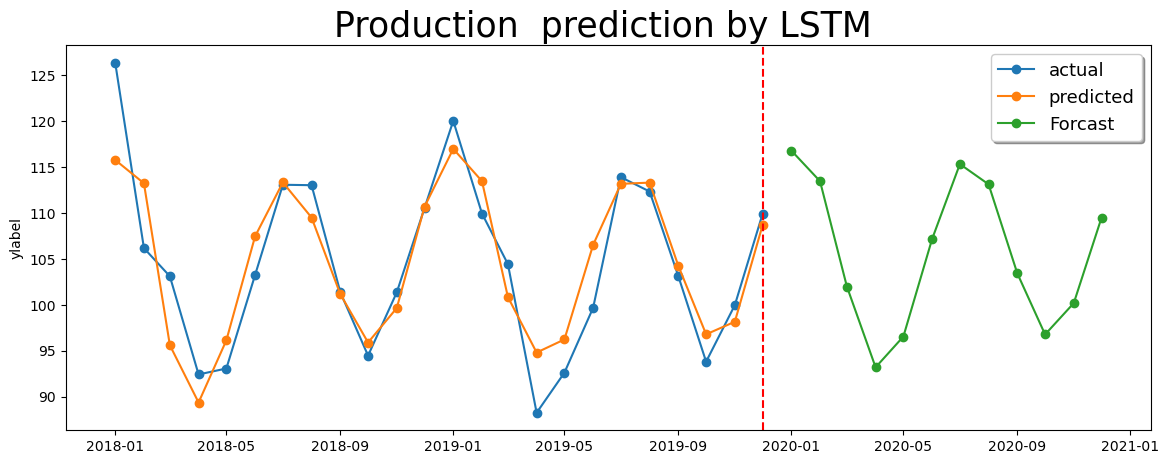

In [55]:
plt.figure(figsize=(14,5))
plt.plot(df_pred.index,df_pred["production"], label="actual", marker="o")
plt.plot(df_pred.index,df_pred["prediction"], label="predicted", marker="o")
plt.plot(df_forecast.index,df_forecast["prediction"], label="Forcast", marker="o")
plt.axvline(df_pred.index[-1], color="red", linestyle="--")

plt.title("Production  prediction by LSTM ", fontsize=25)
plt.ylabel("ylabel")
plt.legend(title_fontsize=14, fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.show()

This part of building the LSTM model was greatly informed by [Electric Production Forecast](https://www.kaggle.com/code/ludovicocuoghi/electric-production-forecast-lstm-sarima-mape-2-5/notebook).
